# Learning FLPO

In this code, we will implement the hierarchical ML architecture to predict the parameters in the FLPO setup.

In [1]:
import torch
from VRP_Net_L import VRPNet_L
from matplotlib import pyplot as plt
from utils import *
import os
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import time
import LSE_net
from torch import optim

# Loading the Data

In [2]:

seed=42;
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Running on: " , device)
num_drones = 100 # number of FLPO instances
num_facilities = 4
dim_ = 2
# START and END locations: no grads needed
START_locs = torch.rand(num_drones, 1, dim_, requires_grad=False, device=device)
END_locs   = torch.ones((num_drones, 1, dim_), requires_grad=False, device=device)#torch.rand(num_drones, 1, dim_, requires_grad=False, device=device)

# Facility locations: we want grads here
# We create a base tensor with requires_grad=True, then expand it
# F_base = torch.rand(1, num_facilities, dim_, requires_grad=True, device=device)
F_base = torch.mean(START_locs, dim=0).repeat(num_facilities, 1).unsqueeze(0).requires_grad_().to(device)
F_locs = F_base.expand(num_drones, -1, -1)  # view, shares grad with F_base
data = torch.cat((START_locs, F_locs, END_locs), dim=1)  # shape: (Nd, Nf+2, D)
print("Data Loaded.")


Running on:  cpu
Data Loaded.


In [3]:
F_base.shape

torch.Size([1, 4, 2])

# Loading the VRP NET Module

In [4]:
hidden_dim = 32
num_layers_enc = 1
num_layers_dec = 1
num_heads = 8
torch.cuda.empty_cache()
vrp_net = VRPNet_L(dim_, hidden_dim, device, num_layers_enc, num_layers_dec, num_heads)
if torch.cuda.is_available():
    vrp_net.load_state_dict(torch.load('Saved models/POMO2025_04_12 00_54_260.6350972652435303best_model.pth',weights_only=True))
else:
    vrp_net.load_state_dict(torch.load('Saved models/POMO2025_04_12 00_54_260.6350972652435303best_model.pth',weights_only=False, map_location=torch.device('cpu')))
vrp_net.eval()

# for param in vrp_net.parameters():
#     param.requires_grad = False
print('VRP NET loaded on: ',vrp_net.device)
print(summary(vrp_net))

VRP NET loaded on:  cpu
Layer (type:depth-idx)                                                 Param #
VRPNet_L                                                               --
├─LinearAttnEncoder: 1-1                                               2,560
│    └─MultiheadAttention: 2-1                                         197,376
│    │    └─NonDynamicallyQuantizableLinear: 3-1                       65,792
│    └─Linear: 2-2                                                     768
│    └─Linear: 2-3                                                     8,224
│    └─LayerNorm: 2-4                                                  512
│    └─Dropout: 2-5                                                    --
│    └─ReLU: 2-6                                                       --
├─Decoder: 1-2                                                         --
│    └─TransformerDecoder: 2-7                                         --
│    │    └─ModuleList: 3-2                                       

# Loading lseNet

In [5]:

lse_data = torch.load('logSumExp_models/dnn_2543_1624.pth', weights_only=False)
n_inputs = lse_data['n_inputs']
n_outputs = lse_data['n_outputs']
layers = lse_data['layers']
weights = lse_data['model_state_dict']
lse_net = LSE_net.dnn(n_inputs, n_outputs, layers)
lse_net.to(device)
lse_net.load_state_dict(weights)
lse_net.eval()
for p in lse_net.parameters():
    p.requires_grad = False
print(f'n_inputs:{n_inputs}\tn_outputs:{n_outputs}\tlayers:{layers}\nlse_net:\n{lse_net}')
print(summary(lse_net))

n_inputs:3	n_outputs:1	layers:[20, 10]
lse_net:
dnn(
  (layers): ModuleList(
    (0): Linear(in_features=3, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)
Layer (type:depth-idx)                   Param #
dnn                                      --
├─ModuleList: 1-1                        --
│    └─Linear: 2-1                       (80)
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       (210)
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       (11)
Total params: 301
Trainable params: 0
Non-trainable params: 301


In [6]:
num_epochs = 200;
optimizer = optim.Adam([F_base], lr=1e-3)
b_arr = torch.tensor(lse_data['b_arr'], dtype=torch.float32)
len_Darray = torch.tensor(lse_data['len_Darray'], dtype=torch.float32)
io_scale = lse_data['io_scale']
b_min = b_arr[0]
b_max = b_arr[-1]

# beta=b_min
for beta in b_arr[0::10]:
    print(f"beta:{beta:.3e}")
    for epoch in range(num_epochs):
        s = time.time()
        with torch.no_grad():
            # forward pass: no activations are saved for grad
            _, actions = vrp_net(data, mod='eval_greedy')
        e = time.time()
        actions.detach()
        d_mins = route_cost(data,actions)
        torch.cuda.empty_cache()
        In = torch.cat((torch.ones((num_drones,1)).to(device)*(-io_scale/b_min*torch.log(len_Darray)).to(device), io_scale*d_mins.view(-1,1), torch.ones((num_drones,1)).to(device)*beta.to(device)), axis=1) #, torch.ones((num_drones,1)).to(device)*b_min.to(device)),axis=1)
        Out = lse_net(In)
        FreeEnergy = torch.mean(Out)/io_scale
        
        # print(torch.norm(data))
        optimizer.zero_grad()
        FreeEnergy.backward()
        optimizer.step()
        F_locs = F_base.expand(num_drones, -1, -1)  
        data = torch.cat((START_locs, F_locs, END_locs), dim=1)
        if epoch % 10 == 0:
            print(f"\tTime: {e-s:.2f}s\tFreeEnergy: {FreeEnergy:.2f}\tF_Grad: {torch.norm(F_base.grad):.3e}")
    
    


beta:1.000e-02
	Time: 0.02s	FreeEnergy: -519.25	F_Grad: 1.864e-01
	Time: 0.02s	FreeEnergy: -519.25	F_Grad: 1.711e-01
	Time: 0.01s	FreeEnergy: -519.26	F_Grad: 1.588e-01
	Time: 0.01s	FreeEnergy: -519.26	F_Grad: 1.133e-01
	Time: 0.01s	FreeEnergy: -519.26	F_Grad: 1.400e-01
	Time: 0.01s	FreeEnergy: -519.26	F_Grad: 1.670e-01
	Time: 0.01s	FreeEnergy: -519.26	F_Grad: 1.670e-01
	Time: 0.01s	FreeEnergy: -519.26	F_Grad: 1.442e-01
	Time: 0.02s	FreeEnergy: -519.26	F_Grad: 1.516e-01
	Time: 0.02s	FreeEnergy: -519.26	F_Grad: 1.691e-01
	Time: 0.02s	FreeEnergy: -519.26	F_Grad: 1.445e-01
	Time: 0.01s	FreeEnergy: -519.26	F_Grad: 1.587e-01
	Time: 0.01s	FreeEnergy: -519.27	F_Grad: 1.541e-01
	Time: 0.01s	FreeEnergy: -519.27	F_Grad: 1.434e-01
	Time: 0.01s	FreeEnergy: -519.27	F_Grad: 1.347e-01
	Time: 0.01s	FreeEnergy: -519.27	F_Grad: 1.624e-01
	Time: 0.01s	FreeEnergy: -519.27	F_Grad: 1.414e-01
	Time: 0.02s	FreeEnergy: -519.27	F_Grad: 1.602e-01
	Time: 0.02s	FreeEnergy: -519.27	F_Grad: 1.496e-01
	Time: 0.01s	Fre

# Plotting some results

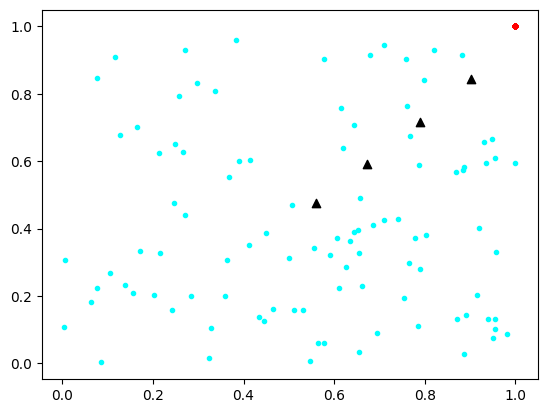

In [7]:
start_locs = START_locs.squeeze(1).cpu().numpy()
plt.scatter(start_locs[:,0],start_locs[:,1],color='cyan',marker='.')
end_locs = END_locs.squeeze(1).cpu().numpy()
plt.scatter(end_locs[:,0],end_locs[:,1],color='red',marker='.')
f_locs = F_base.squeeze(0).detach().cpu().numpy()
plt.scatter(f_locs[:,0],f_locs[:,1],color='black',marker='^')

In [15]:
# all_samples = torch.zeros(num_data, num_nodes, num_samples).to(device)
# for i in range(num_samples):
#     _, actions = vrpnet(data, mod='train')
#     all_samples[:,:,i:i+1] = actions
# opt_sample_indices = []


In [16]:
# d_mins = np.zeros(num_data)
# for data_idx in range(num_data):
#     costs_for_data = [route_cost(data[data_idx:data_idx+1], all_samples[data_idx:data_idx+1, :, sample_idx]) for sample_idx in range(num_samples)]
#     costs_tensor = torch.tensor(costs_for_data)
#     d_min, opt_sample_index = torch.min(costs_tensor, dim=0)  
#     opt_sample_indices.append(opt_sample_index.item())
#     d_mins[data_idx] = d_min
# opt_sample_indices = torch.tensor(opt_sample_indices)
# actions = all_samples[torch.arange(num_data),:,opt_sample_indices]
# print("d_mins for all data are: ",d_mins)

# Loading Free Energy Network

Dhananjay's code for loading his DNN is here. The output of this block should be Y.

# Calculating Free Energy

Feeding the d_min from Salar Block to get the Free energy

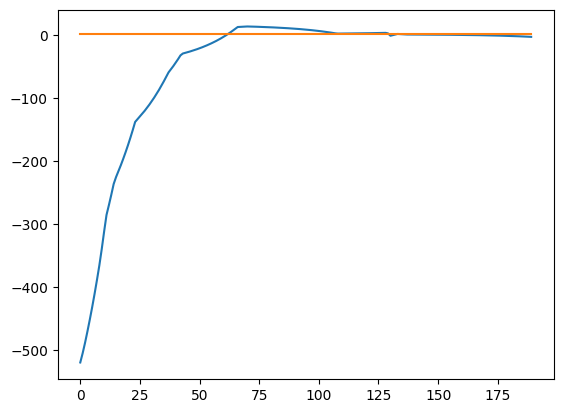

In [59]:
Out_numpy = Out.view(-1).detach().numpy()/io_scale
plt.plot(Out_numpy)
plt.plot(d_min_random*np.ones(Out_numpy.shape))
plt.show()

# Calculating the gradients

The output of this block shoud be dF/dy

First calculate $\frac{\partial F}{\partial d_{min}}$ (code in progress)

In [63]:
# fix beta
b = np.random.choice(b_arr)
d_mins_torch = torch.tensor(d_mins, dtype=torch.float32, requires_grad=True).view(-1,1)
const_bmin = -io_scale/b_arr[0] * np.log(len_Darray) * torch.ones(len(d_mins), dtype=torch.float32).view(-1,1)
const_b = b * torch.ones(len(d_mins), dtype=torch.float32).view(-1,1)
In = torch.concatenate((const_bmin, d_mins_torch, const_b), axis=1)
Out = lse_net(In)
# print(Out)
Out[0].retain_grad()
Out[0].backward()
d_mins_torch.grad

/var/folders/sh/ndxykdmj1q9cwr2kpvkvcbs80000gn/T/ipykernel_89473/1274708057.py:11: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  d_mins_torch.grad


# Running CLF to determin Y

The GD code here

# Closing the Beta Loop for Annealing

In [30]:
import torch

x = torch.arange(20)  # Just an example tensor: [0, 1, 2, ..., 19]

# Create a mask to skip every 5th element
mask = torch.zeros(len(x), dtype=bool)
mask[0::5] = True  # Set every 5th element to False
print(mask)
result = x[mask]

print("Original:", x)
print("Filtered:", result)


tensor([ True, False, False, False, False,  True, False, False, False, False,
         True, False, False, False, False,  True, False, False, False, False])
Original: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19])
Filtered: tensor([ 0,  5, 10, 15])
